# Simulated Annealing

## Template SA

```python
import random
import math

def objective_function(solution):
    # Your objective function implementation here
    # Evaluate the quality of the solution and return a fitness score
    pass

def generate_neighbor(solution):
    # Your neighbor generation function here
    # Generate a neighboring solution based on the current solution
    pass

def acceptance_probability(current_fitness, new_fitness, temperature):
    if new_fitness > current_fitness:
        return 1.0
    else:
        return math.exp((new_fitness - current_fitness) / temperature)

def simulated_annealing(initial_solution, initial_temperature, cooling_rate):

    current_solution = initial_solution
    current_fitness = objective_function(current_solution)

    best_solution = current_solution
    best_fitness = current_fitness

    temperature = initial_temperature

    while temperature > 0.1:  # Adjust the termination condition as needed
        
        new_solution = generate_neighbor(current_solution)
        new_fitness = objective_function(new_solution)

        acceptance_prob = acceptance_probability(current_fitness, new_fitness, temperature)
        
        if random.random() < acceptance_prob:
            current_solution = new_solution
            current_fitness = new_fitness

        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness

        temperature *= cooling_rate

    return best_solution, best_fitness

# Example usage
initial_solution = ...  # Initialize your initial solution
initial_temperature = ...  # Set the initial temperature
cooling_rate = ...  # Set the cooling rate

best_solution, best_fitness = simulated_annealing(initial_solution, initial_temperature, cooling_rate)

print("Best solution:", best_solution)
print("Best fitness:", best_fitness)
```

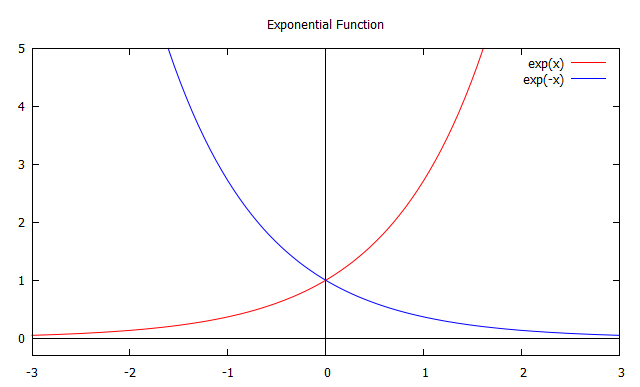

## SA aplicado ao TSP - animação

In [1]:
#%matplotlib inline

### Importações

In [2]:
import numpy as np
import math
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Funções para plotar os gráficos

In [3]:
def plot_path(cities_xy, cities_path, ax):

    # Reeordena as cidades pela ordem do caminho
    cities = cities_xy[cities_path]

    # Repete a primeira cidade para fechar o ciclo
    x = cities[:,0]
    y = cities[:,1]

    # Personalização do gráfico
    ax.set_xlabel('X (Longitude)')
    ax.set_ylabel('Y (Latitude)')
    ax.set_title('Caminho')

    # Plotagem das coordenadas interligadas com pontos vermelhos e linhas azuis
    ax.plot(x, y, color='blue', linestyle='-', linewidth=2)
    ax.plot(x, y, color='red', marker='o', markersize=8, linestyle='')
    ax.plot(x[[-1,0]], y[[-1,0]], color='orange', linestyle='-', linewidth=2)

def plot_distances(iteration_list, distance_list, best_distances, ax):

    x  = iteration_list
    y1 = distance_list
    y2 = best_distances

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Distâncias (custos)')
    ax.set_title('Comprimento Total do caminho')

    ax.plot(x,y1, label='Atual')
    ax.plot(x,y2, label='Melhor')
    ax.legend()

def plot_acceptance_prob(iteration_list, accept_p_list, ax):

    x = iteration_list
    y = accept_p_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    # Criar uma nova lista de cores com base nos valores de y
    xc, yc, colors = zip(*[(xi, yi, 'b') if yi==1.0 else (xi, yi, 'r') \
                           for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

def plot_temperature(iteration_list, temperat_list, ax):

    x = iteration_list
    y = temperat_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.set_ylim([0, 1000])

    ax.plot(x,y)

#----------------------------------------------------------------

def plot_axes_figure(cities_xy, cities_path, iteration_list,
                     distance_list, best_distances,
                     accept_p_list, temperat_list):

    x = iteration_list
    y1 = distance_list
    y2 = best_distances
    y3 = accept_p_list
    y4 = temperat_list

    clear_output(wait=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

    plot_path(cities_xy, cities_path, ax1)
    plot_distances      (x, y1, y2, ax2)
    plot_acceptance_prob(x, y3, ax3)
    plot_temperature    (x, y4, ax4)

    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()

    plt.pause(0.001)

#-----------------------------------------------------
#-----------------------------------------------------


### Implementação do SA aplicado ao TSP

In [8]:
def calculate_distance(city_a, city_b):
    dx = city_a[0] - city_b[0]
    dy = city_a[1] - city_b[1]
    # calculo da distancia euclidiana
    dist = math.sqrt(dx**2 + dy**2)
    return dist

def total_distance(route, distance_matrix):
    total = 0
    for i in range(len(route) - 1):
        city_a = route[i]
        city_b = route[i + 1]
        total += distance_matrix[city_a, city_b]

    total += distance_matrix[route[-1], route[0]]

    return total

def generate_neighbor(route):
    new_route = route.copy()
    n = len(new_route)
    index_a = random.randint(0, n-1)
    index_b = random.randint(0, n-1)
    new_route[index_a], new_route[index_b] = new_route[index_b], new_route[index_a]
    return new_route

def acceptance_probability(current_distance, new_distance, temperature):
    if new_distance < current_distance: # melhor == menor (<)
        return 1.0
    else:
        delta = (current_distance - new_distance)
        return math.exp(delta / temperature)

def generate_distance_matrix(cities):
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i, j] = calculate_distance(cities[i], cities[j])

    return distance_matrix, num_cities

def simulated_annealing(cities, initial_temperature, cooling_rate, iterations, nrep=50):

    num_cities = len(cities)
    
    # Histórico para gerar o gráfico de evolução
    fitness_history = []

    distance_matrix, num_cities = generate_distance_matrix(cities)

    current_route = np.arange(num_cities)
    best_route = current_route.copy()

    current_distance = total_distance(current_route, distance_matrix)
    best_distance = current_distance

    temperature = initial_temperature

    #-----------------------------------------------
    iteration_list = []
    best_distances = []
    distance_list  = []
    accept_p_list  = []
    temperat_list  = []
    #-----------------------------------------------

    # Define o ponto de corte (90% das iterações) onde a probabilidade chega a 0
    cutoff_iteration = int(0.9 * iterations)
    
    for iteration in range(iterations):

        # Calcula a probabilidade linear de aceitar vizinhos piores
        # Inicialmente 1.0, reduzindo linearmente até 0.0 na iteração de corte
        if iteration < cutoff_iteration:
            linear_prob = 1.0 - (iteration / cutoff_iteration)
        else:
            linear_prob = 0.0

        # numero de vizinhos a serem gerados e testados para cada iteração
        for _ in range(nrep):

            new_route = generate_neighbor(current_route)
            new_distance = total_distance(new_route, distance_matrix)

            acceptance_prob = acceptance_probability(current_distance, new_distance, temperature)

            #print(acceptance_prob)

            if random.random() < acceptance_prob:
                current_route = new_route
                current_distance = new_distance

        temperature *= cooling_rate


        #-----------------------------------------------
        if new_distance < best_distance:
            best_route = new_route
            best_distance = new_distance
            # Salva o melhor encontrado até o momento para o gráfico de evolução
            fitness_history.append(best_distance)

        iteration_list += [iteration]
        best_distances += [best_distance]
        distance_list  += [current_distance]
        accept_p_list  += [acceptance_prob]
        temperat_list  += [temperature]

        if iteration % 50 == 0:
            plot_axes_figure(cities, current_route, iteration_list,
                            distance_list, best_distances,
                            accept_p_list, temperat_list)
        #-----------------------------------------------

    # plt.show()

    return best_route, best_distance, fitness_history


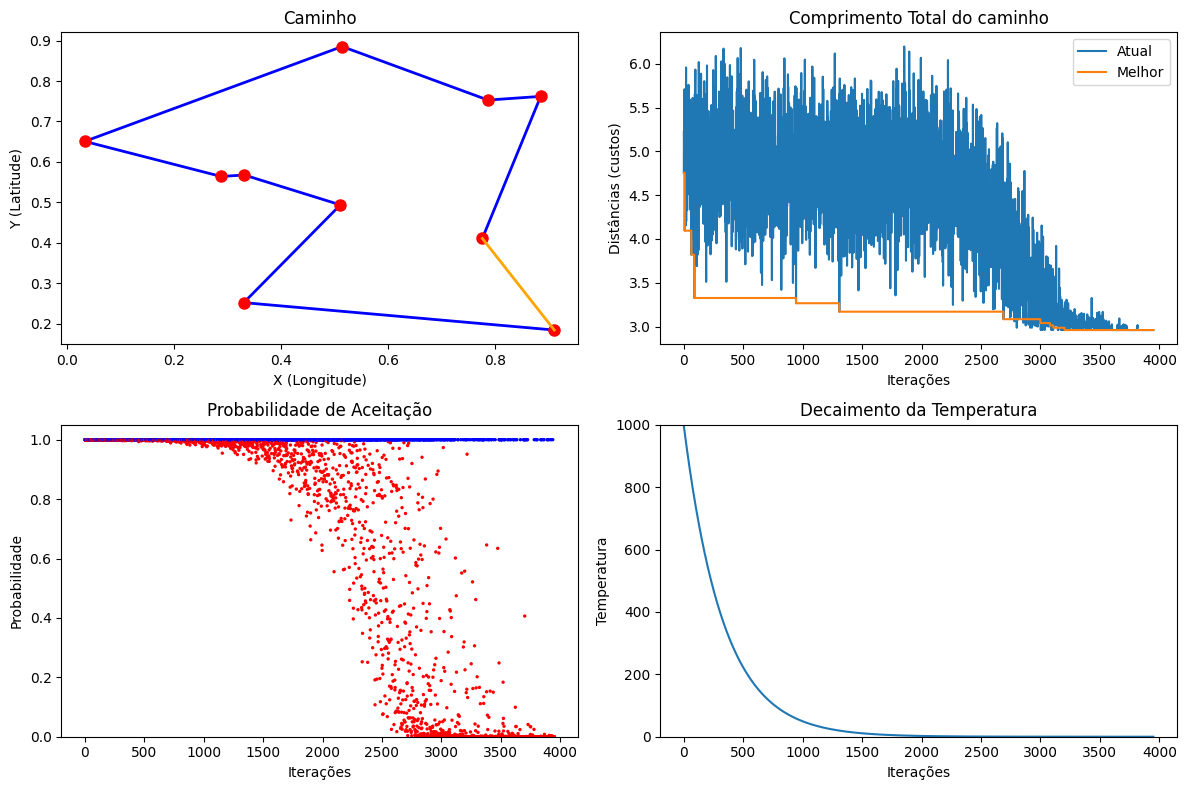

Best route: [2 7 3 8 6 4 0 1 9 5]
Best distance: 2.960509208901976
Fitness history: [np.float64(4.756003089620345), np.float64(4.0946136040649295), np.float64(3.8207101026425097), np.float64(3.3264937872516573), np.float64(3.266558282958896), np.float64(3.1700778725154923), np.float64(3.084514726871288), np.float64(3.040200922255334), np.float64(3.0130641317941937), np.float64(2.9869438669110586), np.float64(2.960509208901976)]


In [9]:
def main():
    # Exemplo de uso
    num_cities = 10
    cities = np.random.rand(num_cities, 2)

    initial_temperature = 1000.0    # 100 200 500 1000 2000
    cooling_rate = 0.997            # 0.99, 0.995, 0.997 0.999
    iterations = 4000

    best_route, best_distance, history = simulated_annealing(cities, initial_temperature, cooling_rate, iterations)

    print("Best route:", best_route)
    print("Best distance:", best_distance)
    print("Fitness history:", history)


if __name__ == '__main__':
    main()


In [10]:
# Faça o código sem instrumentação
# ...


In [11]:
# Apenas para você averiguar como funcionam
# os calculos de probabilidade
# p = 0.25
# total = 100000
# n_trues = 0

# for i in range(total):
#     if random.random() < p:
#         n_trues += 1

# print (n_trues/total)



---



## Utilizando dados reais

---



1. Adaptar o código do SA para resolver o problema do link abaixo:

    **Western Sahara**

    29 cidades
    The optimal tour has length 27.603

    Foto dos Pontos: http://www.math.uwaterloo.ca/tsp/world/wipoints.html

    Foto da Solução: http://www.math.uwaterloo.ca/tsp/world/witour.html

    Download dos Dados: http://www.math.uwaterloo.ca/tsp/world/wi29.tsp


In [12]:
import pandas as pd
import time

In [13]:
url_coordenadas_cidade = 'https://www.math.uwaterloo.ca/tsp/world/wi29.tsp'
#url_coordenadas_cidade = 'http://www.math.uwaterloo.ca/tsp/world/qa194.tsp'

df_coordenadas = pd.read_table(
                    url_coordenadas_cidade,
                    skiprows=7,           # ignora as 7 primeiras linhas com informações
                    names=['X', 'Y'],     # nomes das colunas
                    sep=' ',              # separador das colunas
                    index_col=0,          # usar col=0 como index (nome das cidades)
                    skipfooter=1,         # ignora a última linha (EOF)
                    engine='python'       # para o parser usar skipfooter sem warning
              )

In [14]:
# df_coordenadas
NUM_CITIES = len(df_coordenadas)
print(f"Carregadas {NUM_CITIES} cidades do Western Sahara.")

Carregadas 29 cidades do Western Sahara.


In [15]:
def simulated_annealing_tsp_linear(cities, initial_temperature, cooling_rate, iterations, nrep=50):

    num_cities = len(cities)
    
    # Histórico para gerar o gráfico de evolução
    fitness_history = []

    distance_matrix, num_cities = generate_distance_matrix(cities)

    current_route = np.arange(num_cities)
    best_route = current_route.copy()

    current_distance = total_distance(current_route, distance_matrix)
    best_distance = current_distance

    temperature = initial_temperature

    #-----------------------------------------------
    iteration_list = []
    best_distances = []
    distance_list  = []
    accept_p_list  = []
    temperat_list  = []
    #-----------------------------------------------

    # Define o ponto de corte (90% das iterações) onde a probabilidade chega a 0
    cutoff_iteration = int(0.9 * iterations)

    for iteration in range(iterations):

        # Calcula a probabilidade linear de aceitar vizinhos piores
        # Inicialmente 1.0, reduzindo linearmente até 0.0 na iteração de corte
        if iteration < cutoff_iteration:
            linear_prob = 1.0 - (iteration / cutoff_iteration)
        else:
            linear_prob = 0.0

        # numero de vizinhos a serem gerados e testados para cada iteração
        for _ in range(nrep):

            new_route = generate_neighbor(current_route)
            new_distance = total_distance(new_route, distance_matrix)

            # Lógica de aceitação modificada:
            # Se for melhor, aceita (probabilidade 1.0)
            # Se for pior, usa a probabilidade linear calculada
            if new_distance < current_distance:
                acceptance_prob = 1.0
                current_route = new_route
                current_distance = new_distance
            else:
                acceptance_prob = linear_prob
                if random.random() < acceptance_prob:
                    current_route = new_route
                    current_distance = new_distance
            
            # Verifica se encontrou um novo melhor global (dentro do nrep para não perder o ótimo)
            if current_distance < best_distance:
                best_route = current_route.copy()
                best_distance = current_distance
                # Salva o melhor encontrado para o gráfico de evolução
                
        fitness_history.append(best_distance)

        # Mantém atualização da temperatura para os gráficos, embora não afete a aceitação nesta versão
        temperature *= cooling_rate

        #-----------------------------------------------
        # Coleta dados para os gráficos
        iteration_list.append(iteration)
        best_distances.append(best_distance)
        distance_list.append(current_distance)
        accept_p_list.append(linear_prob) # Registra a probabilidade usada na iteração
        temperat_list.append(temperature)

        if iteration % 50 == 0:
            plot_axes_figure(cities, current_route, iteration_list,
                             distance_list, best_distances,
                             accept_p_list, temperat_list)
        #-----------------------------------------------

    # plt.show()

    return best_route, best_distance, fitness_history

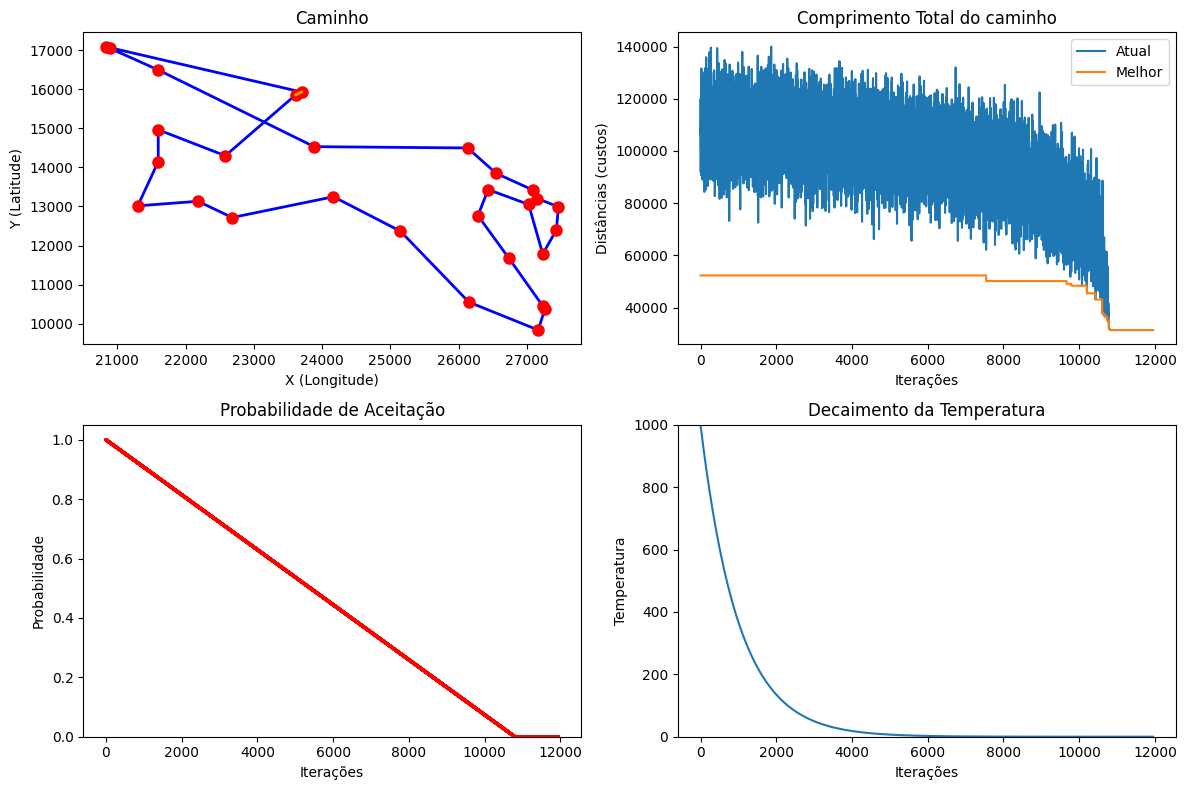

Best route: [ 9  7  4  3  2  6  8 12 13 15 23 26 24 19 16 17 20 25 27 28 22 21 18 14
 11  5  0  1 10]
Best distance: 31366.581376833183


In [16]:
    # Exemplo de uso
    cities = np.array(df_coordenadas)

    initial_temperature = 1000.0    # 100 200 500 1000 2000
    cooling_rate = 0.999            # 0.99, 0.995, 0.997 0.999
    iterations = 12000

    best_route, best_distance, fitness_history = simulated_annealing_tsp_linear(cities, initial_temperature, cooling_rate, iterations)
    #best_route, best_distance, fitness_history = simulated_annealing_tsp_linear(iterations)


    print("Best route:", best_route)
    print("Best distance:", best_distance)

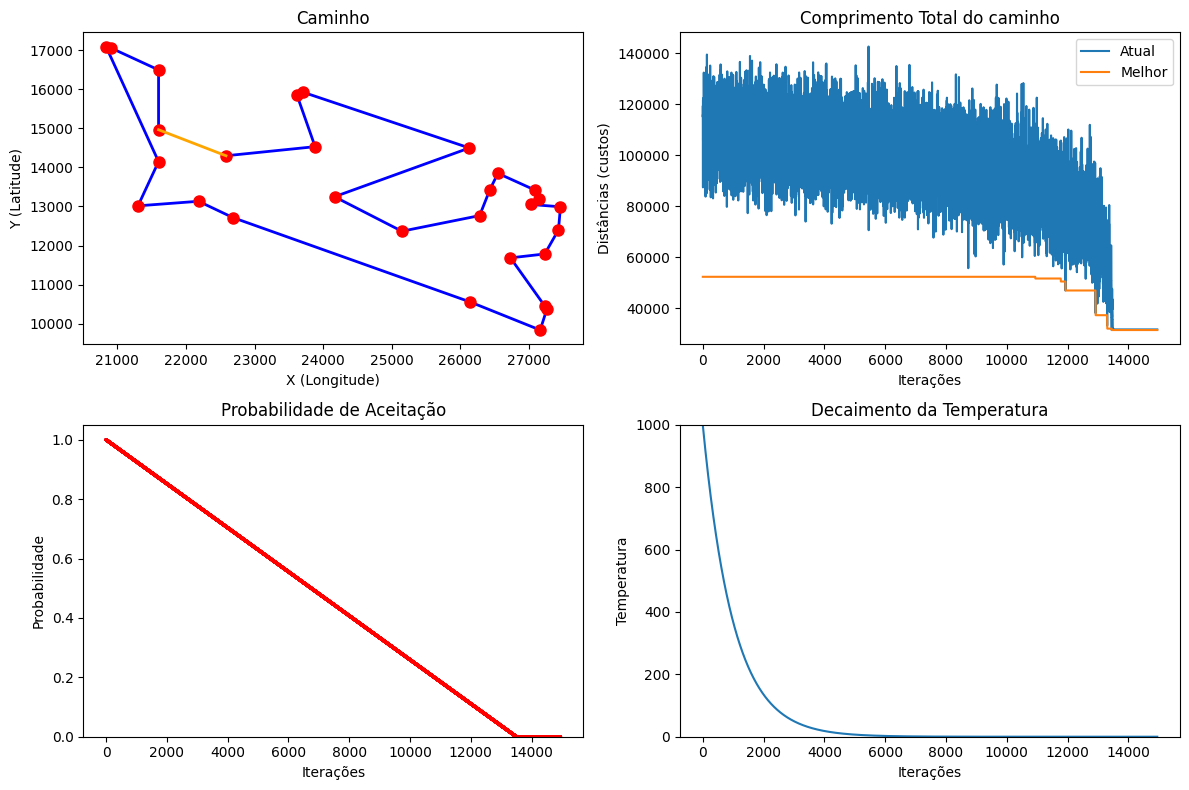


Tempo total: 261.10 segundos

=== ESTATÍSTICAS (2 Execuções) / 15000 iterações  ===
Máximo (Pior): 35088.19
Mínimo (Melhor): 31399.85
Média: 33244.02
Mediana: 33244.02
Desvio Padrão: 1844.17
Ótimo Conhecido (Ref): 27603


In [19]:
# Parâmetros
# Ajuste o número de iterações conforme necessário. 
# O problema tem 29 cidades, o espaço de busca é 28!
# Valores baixos (ex: 1000) rodam rápido, mas dão resultados ruins.
# Valores altos (ex: 100000) dão resultados melhores.
N_ITERATIONS = 15000
N_EXECUTIONS = 2

results_costs = []
all_histories = []
best_overall_tour = None
min_overall_cost = float('inf')

print(f"Iniciando {N_EXECUTIONS} execuções do SA com {N_ITERATIONS} iterações cada...")

start_time = time.time()

for i in range(N_EXECUTIONS):
    #tour, cost, history = simulated_annealing_tsp_linear(N_ITERATIONS)
    #tour, cost, history = simulated_annealing(cities, initial_temperature, cooling_rate, iterations)
    tour, cost, history = simulated_annealing_tsp_linear(cities, initial_temperature, cooling_rate, N_ITERATIONS)
    results_costs.append(cost)
    all_histories.append(history)
    
    if cost < min_overall_cost:
        min_overall_cost = cost
        best_overall_tour = tour
        
    if (i+1) % 5 == 0:
        print(f"Execução {i+1}/{N_EXECUTIONS} concluída. Melhor custo local: {cost:.2f}")

end_time = time.time()
print(f"\nTempo total: {end_time - start_time:.2f} segundos")

# Estatísticas
results_costs = np.array(results_costs)
print(f"\n=== ESTATÍSTICAS ({N_EXECUTIONS} Execuções) / {N_ITERATIONS} iterações  ===")
print(f"Máximo (Pior): {np.max(results_costs):.2f}")
print(f"Mínimo (Melhor): {np.min(results_costs):.2f}")
print(f"Média: {np.mean(results_costs):.2f}")
print(f"Mediana: {np.median(results_costs):.2f}")
print(f"Desvio Padrão: {np.std(results_costs):.2f}")
print(f"Ótimo Conhecido (Ref): 27603") # Valor aproximado para wi29 sem normalização float

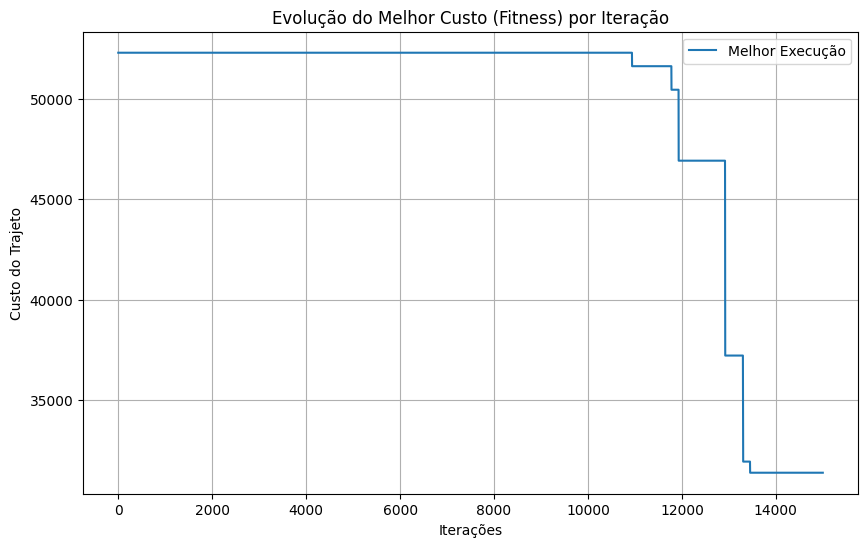

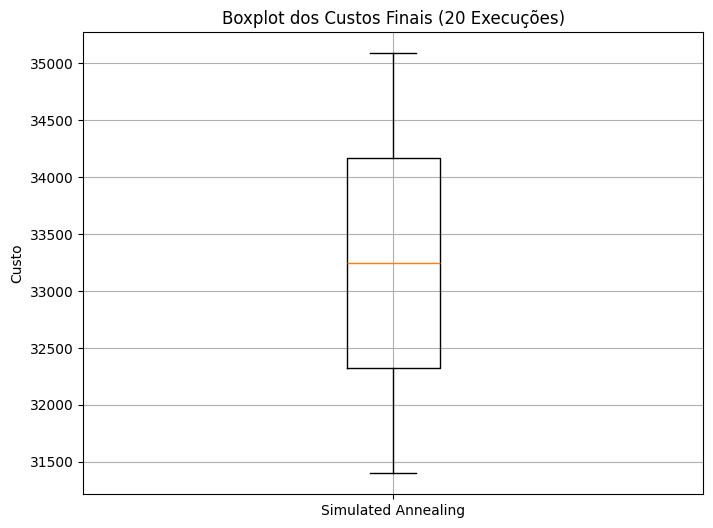

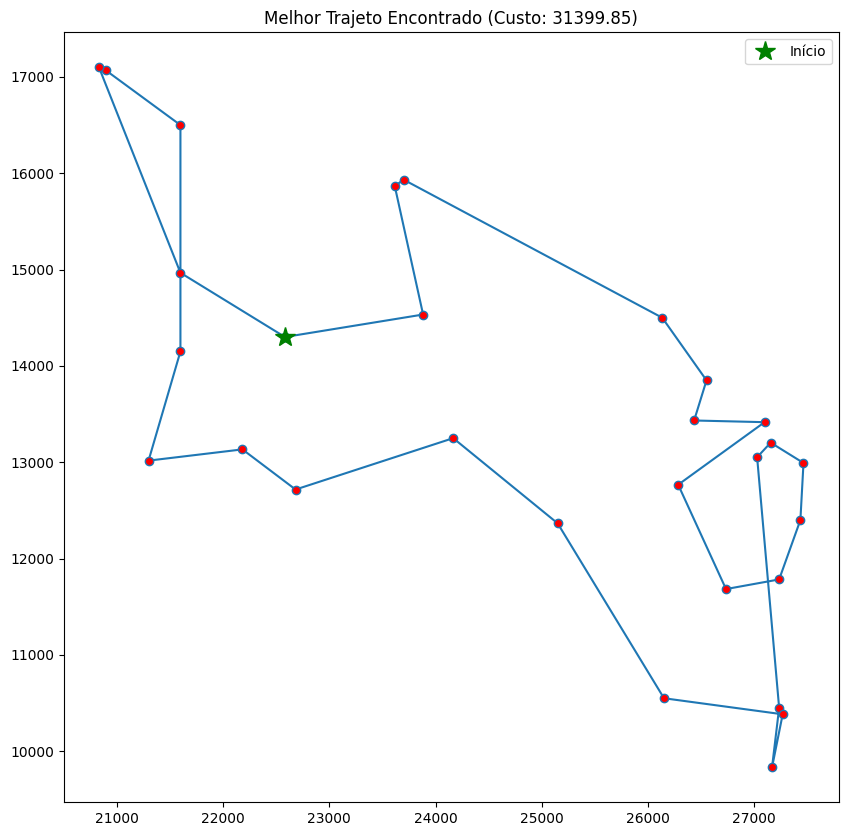

In [20]:
# 1. Gráfico de Evolução (Fitness vs Iterações) - Uma execução representativa (a melhor)
best_run_index = np.argmin(results_costs)
plt.figure(figsize=(10, 6))
plt.plot(all_histories[best_run_index], label='Melhor Execução')
plt.title('Evolução do Melhor Custo (Fitness) por Iteração')
plt.xlabel('Iterações')
plt.ylabel('Custo do Trajeto')
plt.legend()
plt.grid(True)
plt.show()

# 2. Boxplot dos Resultados
plt.figure(figsize=(8, 6))
plt.boxplot(results_costs)
plt.title('Boxplot dos Custos Finais (20 Execuções)')
plt.ylabel('Custo')
plt.xticks([1], ['Simulated Annealing'])
plt.grid(True)
plt.show()

# 3. Visualização do Melhor Caminho Encontrado (Mapa)
# Dados do Western Sahara (wi29) hardcoded para facilitar o teste
# Se preferir ler do arquivo, use a função load_tsp_file abaixo
WI29_COORDS = """
1 20833.3333 17100.0000
2 20900.0000 17066.6667
3 21300.0000 13016.6667
4 21600.0000 14150.0000
5 21600.0000 14966.6667
6 21600.0000 16500.0000
7 22183.3333 13133.3333
8 22583.3333 14300.0000
9 22683.3333 12716.6667
10 23616.6667 15866.6667
11 23700.0000 15933.3333
12 23883.3333 14533.3333
13 24166.6667 13250.0000
14 25149.1667 12365.8333
15 26133.3333 14500.0000
16 26150.0000 10550.0000
17 26283.3333 12766.6667
18 26433.3333 13433.3333
19 26550.0000 13850.0000
20 26733.3333 11683.3333
21 27026.1111 13051.9444
22 27096.1111 13415.8333
23 27153.6111 13203.3333
24 27166.6667 9833.3333
25 27233.3333 10450.0000
26 27233.3333 11783.3333
27 27266.6667 10383.3333
28 27433.3333 12400.0000
29 27462.5000 12992.2222
"""

def load_data_string(data_str):
    points = []
    for line in data_str.strip().split('\n'):
        parts = line.split()
        # Ignora o índice (parts[0]) e pega X, Y
        points.append([float(parts[1]), float(parts[2])])
    return np.array(points)

# Carrega as coordenadas das cidades
cities_coords = load_data_string(WI29_COORDS)

def plot_best_tour(cities, tour, cost):
    x = cities[tour, 0]
    y = cities[tour, 1]
    
    # Adiciona o ponto inicial ao final para fechar o ciclo
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    
    plt.figure(figsize=(10, 10))
    plt.plot(x, y, 'o-', mfc='r')
    plt.title(f'Melhor Trajeto Encontrado (Custo: {cost:.2f})')
    
    # Marcar início
    plt.plot(x[0], y[0], 'g*', markersize=15, label='Início')
    plt.legend()
    plt.show()

plot_best_tour(cities_coords, best_overall_tour, min_overall_cost)

# Minimização da Função de Rastrigin

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

# --- CONFIGURAÇÕES DO PROBLEMA 2 (RASTRIGIN) ---
BOUNDS = [-5.12, 5.12]
    
def function_rastrigin(x, y):
    """
    Função de Rastrigin: f(x,y) = 20 + x^2 - 10cos(2πx) + y^2 - 10cos(2πy)
    Função Objetivo: Rastrigin (Minimização)."""
    return 20 + (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y))

In [22]:
def generate_neighbor_rastrigin(current_solution):
    """
    Gera vizinho somando valor aleatório (distribuição normal, média 0, desvio 0.2)
    às coordenadas x e y. Garante que o ponto fique dentro do intervalo [-5.12, 5.12].
    """
    x, y = current_solution
    
    # Perturbação gaussiana (média 0, desvio 0.2)
    dx = np.random.normal(0, 0.2)
    dy = np.random.normal(0, 0.2)
    
    new_x = np.clip(x + dx, BOUNDS[0], BOUNDS[1])
    new_y = np.clip(y + dy, BOUNDS[0], BOUNDS[1])
    
    return [new_x, new_y]

In [23]:
def get_linear_probability(iteration, cutoff_iteration):
    """
    Probabilidade de aceitação linear:
    - Inicia em 1.0
    - Chega a 0.0 na iteração de corte (900 conforme PDF)
    - Mantém 0.0 após o corte
    """
    if iteration >= cutoff_iteration:
        return 0.0
    return 1.0 - (iteration / cutoff_iteration)

In [24]:
def plot_rastrigin_3d(current_solution, current_val, best_solution, best_val, iteration):
    """
    Gera/Atualiza o gráfico 3D da função com o ponto atual.
    """
    clear_output(wait=True)
    
    # Configuração do Grid para a superfície
    x = np.linspace(BOUNDS[0], BOUNDS[1], 100)
    y = np.linspace(BOUNDS[0], BOUNDS[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = function_rastrigin(X, Y)
    
    fig = plt.figure(figsize=(12, 6))
    
    # --- PLOT 1: Superfície 3D com o ponto ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    
    # Plota a superfície (com transparência alpha=0.6 para ver o ponto)
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6, edgecolor='none')
    
    # Plota o ponto atual (vermelho)
    cx, cy = current_solution
    cz = current_val
    ax1.scatter(cx, cy, cz, color='red', s=100, label='Atual', zorder=10)
    
    # Plota o melhor ponto até agora (verde)
    bx, by = best_solution
    bz = best_val
    ax1.scatter(bx, by, bz, color='green', s=100, marker='*', label='Melhor', zorder=10)
    
    ax1.set_title(f'Iteração: {iteration} | Valor: {current_val:.4f}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z (Fitness)')
    ax1.legend()
    
    # --- PLOT 2: Mapa de Calor (Visão Superior) ---
    ax2 = fig.add_subplot(1, 2, 2)
    contour = ax2.contourf(X, Y, Z, 20, cmap='viridis')
    plt.colorbar(contour, ax=ax2)
    
    # Pontos no 2D
    ax2.scatter(cx, cy, color='red', s=50, label='Atual')
    ax2.scatter(bx, by, color='green', marker='*', s=100, label='Melhor')
    
    ax2.set_title('Mapa de Contorno (Visão Superior)')
    ax2.set_xlim(BOUNDS)
    ax2.set_ylim(BOUNDS)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [26]:
def simulated_annealing_rastrigin(max_iterations=1500, cutoff_iter=900, plot_interval=50):
    # Solução inicial aleatória
    current_sol = np.random.uniform(BOUNDS[0], BOUNDS[1], 2)
    current_val = function_rastrigin(current_sol[0], current_sol[1])
    
    best_sol = current_sol
    best_val = current_val
    
    history = [best_val]
    
    for i in range(max_iterations):
        # 1. Gera vizinho
        neighbor = generate_neighbor_rastrigin(current_sol)
        neighbor_val = function_rastrigin(neighbor[0], neighbor[1])
        
        # 2. Regra de Aceitação (Linear para piora)
        if neighbor_val < current_val:
            # Melhora: aceita sempre
            current_sol = neighbor
            current_val = neighbor_val
            
            if current_val < best_val:
                best_val = current_val
                best_sol = current_sol
        else:
            # Piora: probabilidade linear
            prob = get_linear_probability(i, cutoff_iter)
            if random.random() < prob:
                current_sol = neighbor
                current_val = neighbor_val
        
        history.append(best_val)
        
        # Atualiza gráfico a cada N iterações para não ficar lento
        if i % plot_interval == 0:
            plot_rastrigin_3d(current_sol, current_val, best_sol, best_val, i)
            # Pequena pausa para animação ficar visível
            # time.sleep(0.01) 
            
    # Plot final
    plot_rastrigin_3d(current_sol, current_val, best_sol, best_val, max_iterations)
    
    return best_sol, best_val, history



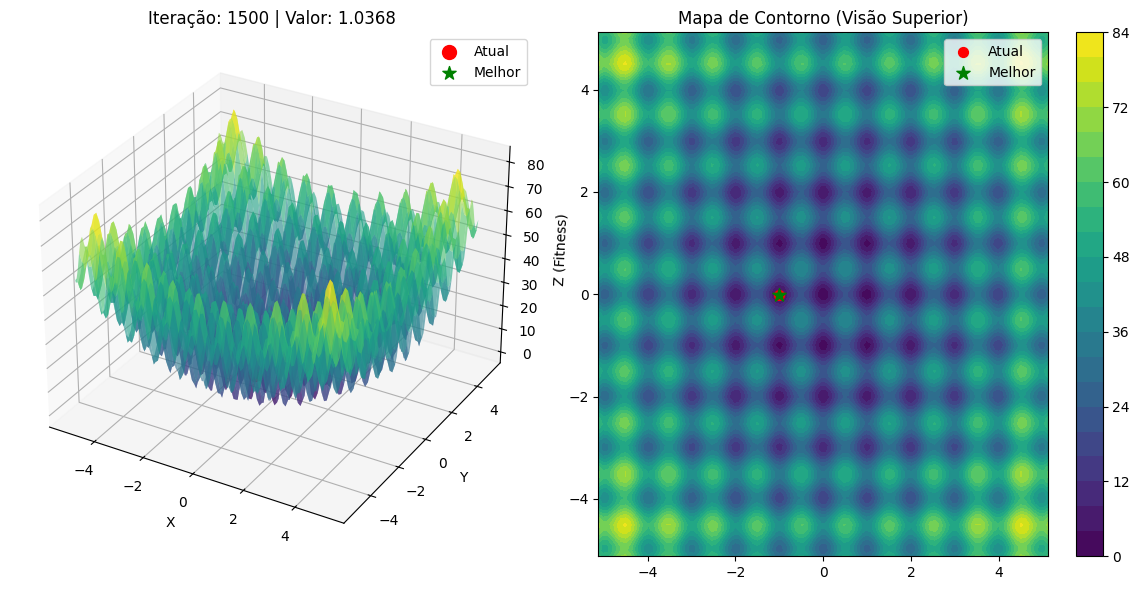


Melhor Solução Encontrada (x, y): [np.float64(-1.000825894866493), np.float64(-0.013286193595241785)]
Melhor Valor (Fitness): 1.03679


In [27]:
# --- EXECUÇÃO (Teste único com visualização) ---
# Parâmetros conforme PDF: 
# "Reduza a probabilidade linearmente de forma a chegar a 0 após 900 iterações"
# "A partir daí, mantenha a probabilidade constante em 0"
best_solution, best_fitness, fit_history = simulated_annealing_rastrigin(
    max_iterations=1500, 
    cutoff_iter=900, 
    plot_interval=100 # Aumente se estiver muito lento
)

print(f"\nMelhor Solução Encontrada (x, y): {best_solution}")
print(f"Melhor Valor (Fitness): {best_fitness:.5f}")

In [43]:
# para rodar várias vezes sem o gráfico para gerar dados do relatório
def simulated_annealing_rastrigin_sem_grafico(max_iterations=1500, cutoff_iter=900):
    # Solução inicial aleatória
    current_sol = np.random.uniform(BOUNDS[0], BOUNDS[1], 2)
    current_val = function_rastrigin(current_sol[0], current_sol[1])
    
    best_sol = current_sol
    best_val = current_val
    
    # Histórico do MELHOR valor encontrado até o momento (para o gráfico de evolução)
    history_best = [best_val]
    
    for i in range(max_iterations):
        # Gera vizinho
        neighbor = generate_neighbor_rastrigin(current_sol)
        neighbor_val = function_rastrigin(neighbor[0], neighbor[1])
        
        # Critério de Aceitação
        accepted = False
        if neighbor_val < current_val:
            accepted = True
        else:
            prob = get_linear_probability(i, cutoff_iter)
            if random.random() < prob:
                accepted = True
        
        if accepted:
            current_sol = neighbor
            current_val = neighbor_val
            
            # Atualiza o melhor global encontrado
            if current_val < best_val:
                best_val = current_val
                best_sol = current_sol
        
        history_best.append(best_val)
        
    return best_val, history_best

In [50]:
# --- 3. EXECUÇÃO MÚLTIPLA (20 VEZES) ---
N_EXEC = 20
results_final_values = []
results_histories = []

print(f"Executando SA {N_EXEC} vezes na função Rastrigin...")
for i in range(N_EXEC):
    final_val, hist = simulated_annealing_rastrigin_sem_grafico()
    results_final_values.append(final_val)
    results_histories.append(hist)
    
print(f"Média: {np.mean(sa_results):.5f}")
print(f"Desvio Padrão: {np.std(sa_results):.5f}")
print(f"Melhor Mínimo: {np.min(sa_results):.5f}")

Executando SA 20 vezes na função Rastrigin...
Média: 4.44409
Desvio Padrão: 4.24071
Melhor Mínimo: 0.00694


In [51]:
# --- 4. GERAÇÃO DOS GRÁFICOS E TABELAS ---

# A) Tabela de Sumarização [cite: 55-56]
df_results = pd.DataFrame(results_final_values, columns=['Fitness Final'])
summary = {
    'Algoritmo': ['SA (Rastrigin)'],
    'Max': [df_results['Fitness Final'].max()],
    'Min': [df_results['Fitness Final'].min()],
    'Mediana': [df_results['Fitness Final'].median()],
    'Desvio Padrão': [df_results['Fitness Final'].std()]
}
df_summary = pd.DataFrame(summary)

print("\n--- Tabela de Sumarização ---")
print(df_summary.to_string(index=False))

# Salvar tabela em CSV (opcional, para o relatório)
# df_summary.to_csv('tabela_sumarizacao_rastrigin_sa.csv', index=False)


--- Tabela de Sumarização ---
     Algoritmo       Max      Min  Mediana  Desvio Padrão
SA (Rastrigin) 13.010764 0.017338  4.31986       3.532422


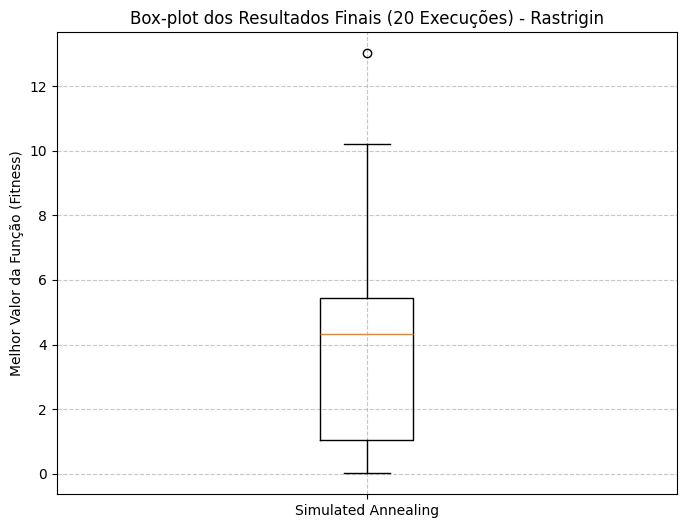

In [53]:
# B) Gráfico Box-plot [cite: 53]
plt.figure(figsize=(8, 6))
plt.boxplot(results_final_values, tick_labels=['Simulated Annealing'])
plt.title('Box-plot dos Resultados Finais (20 Execuções) - Rastrigin')
plt.ylabel('Melhor Valor da Função (Fitness)')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.savefig('boxplot_rastrigin_sa.png') # Salva a figura
plt.show()

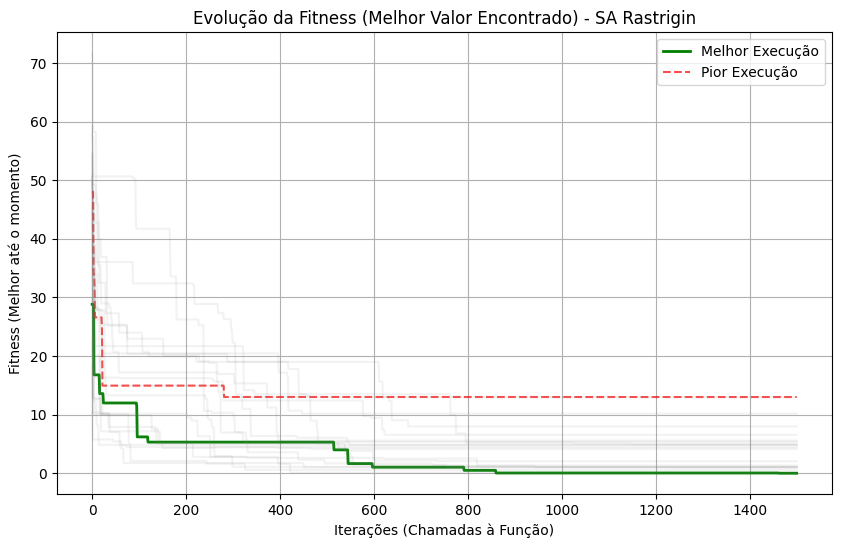

In [56]:
# C) Gráfico da Evolução da Fitness [cite: 57-59]
# Plotando a curva da melhor execução e da pior execução para comparação, ou a média.
# O PDF pede "cada curva deve representar apenas uma das 20 execuções". 
# Vamos plotar a melhor execução (que atingiu o menor valor).

best_run_index = np.argmin(results_final_values)
worst_run_index = np.argmax(results_final_values)

plt.figure(figsize=(10, 6))
# Plota a melhor execução
plt.plot(results_histories[best_run_index], label='Melhor Execução', color='green', linewidth=2)

# Opcional: Plotar a pior para demonstrar variabilidade
plt.plot(results_histories[worst_run_index], label='Pior Execução', color='red', linestyle='--', alpha=0.7)

# Opcional: Plotar todas as execuções em cinza claro no fundo
for hist in results_histories:
    plt.plot(hist, color='gray', alpha=0.1)

plt.title('Evolução da Fitness (Melhor Valor Encontrado) - SA Rastrigin')
plt.xlabel('Iterações (Chamadas à Função)')
plt.ylabel('Fitness (Melhor até o momento)')
plt.legend()
plt.grid(True)
plt.savefig('evolucao_fitness_rastrigin_sa.png') # Salva a figura
plt.show()